# Bank Deposit Classification

### Problem Statement:-

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

Datset taken from Bank Marketing Data Set from UCI Machine Learning Repository

### Importing Libraries and Dataset

In [1]:
# Visualisation and dataframes
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# train-test-split, scaling, encoding 
from sklearn.model_selection import train_test_split


# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# metrics
from sklearn import metrics
from sklearn.metrics import (accuracy_score,
                            recall_score,
                            precision_score, 
                            f1_score,
                            precision_recall_curve,
                            precision_recall_fscore_support, 
                            classification_report, 
                            confusion_matrix,
                            roc_auc_score,
                            roc_curve,
                            plot_confusion_matrix)


# Warnings
import warnings

warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_colwidth',None)
pd.pandas.set_option('display.max_columns',None)

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [3]:
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### EDA

#### Missing and duplicate values

In [4]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [5]:
df.drop_duplicates(inplace = True)
print(df.shape)

(41176, 21)


- there are no null values
- there were **12** duplicate rows that are removed

### Description of Dataset

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41176.0,40.023800,10.420680,17.000,32.000,38.000,47.000,98.000
duration,41176.0,258.315815,259.305321,0.000,102.000,180.000,319.000,4918.000
campaign,41176.0,2.567879,2.770318,1.000,1.000,2.000,3.000,56.000
pdays,41176.0,962.464810,186.937102,0.000,999.000,999.000,999.000,999.000
previous,41176.0,0.173013,0.494964,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41176.0,0.081922,1.570883,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41176.0,93.575720,0.578839,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41176.0,-40.502863,4.627860,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41176.0,3.621293,1.734437,0.634,1.344,4.857,4.961,5.045
nr.employed,41176.0,5167.034870,72.251364,4963.600,5099.100,5191.000,5228.100,5228.100


- From the data, we can observe that the mean age is 40 years with a maximum age of 98 years and minimum age of 17 years
- The average contact duration is 258 seconds

### Distribution of dependant variable classes

<AxesSubplot:xlabel='y', ylabel='count'>

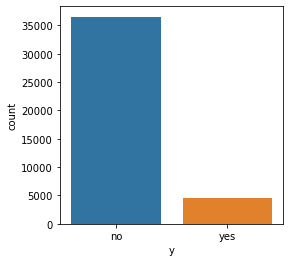

In [7]:
plt.figure(figsize=(4,4))
sns.countplot(data = df, x = 'y')

In [8]:
np.round(df['y'].value_counts()/len(df)*100, 2)

no     88.73
yes    11.27
Name: y, dtype: float64

- **88.73%** of the classes are **`no`** and only **11.27%** of the classes are **`yes`**
- There is a clear misbalance between classes.
- **This can be handled by either using stratify = y, or by sampling**

### Univariate Analysis for Numerical features

In [9]:
# getting all numerical features
numerical = [feature for feature in df.columns if df[feature].dtype != 'O']
print(len(numerical))
numerical

10


['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

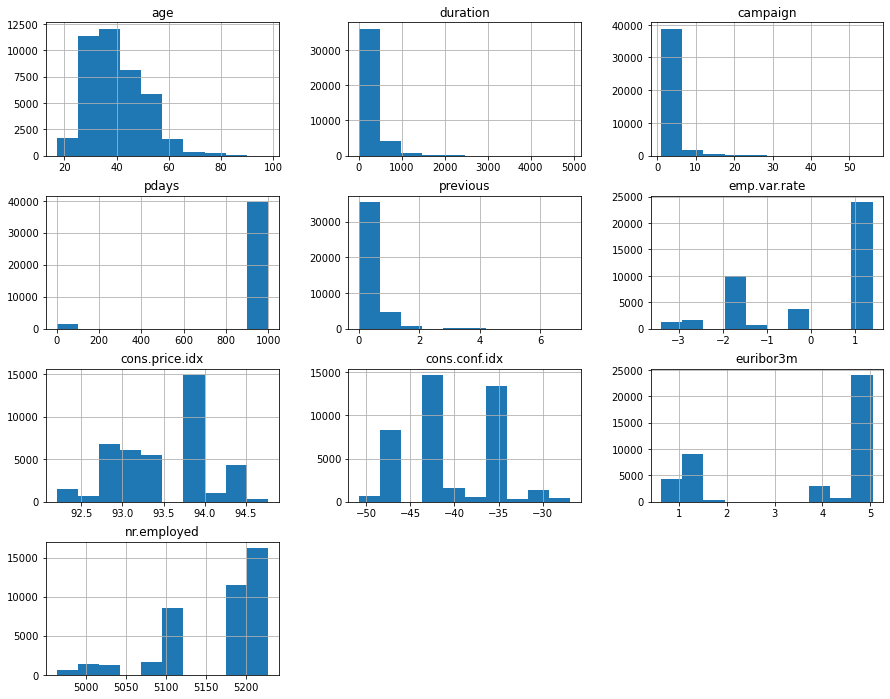

In [10]:
df[numerical].hist(figsize=(15,12))
plt.show()

- **duration, campaign, previous and age** are `right skewed` whereas others are `left skewed`

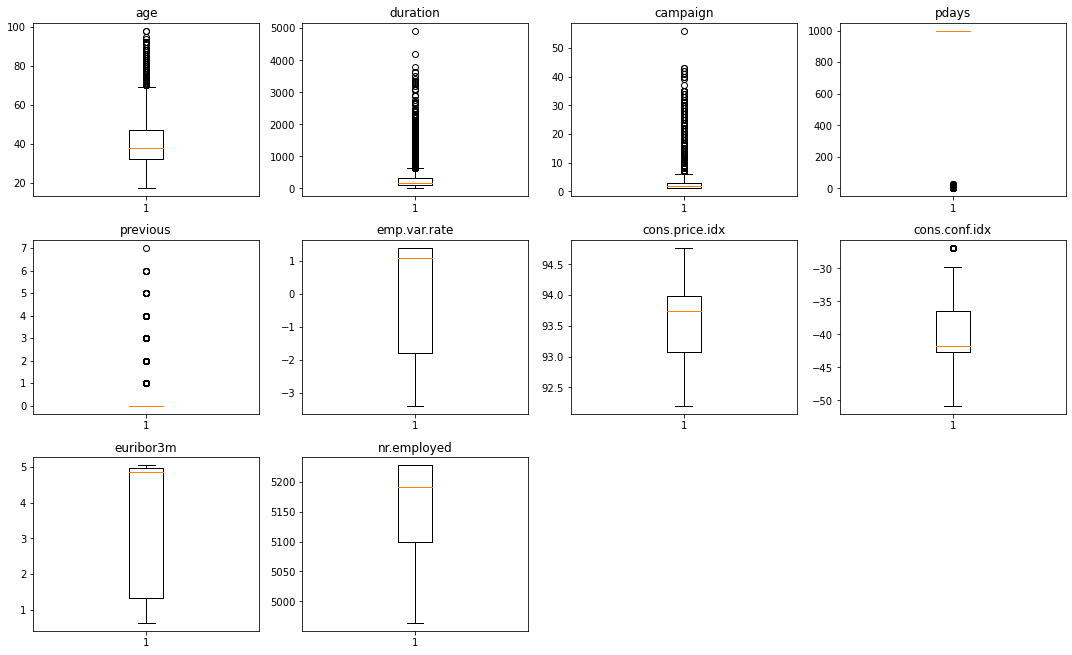

In [11]:
# checking outliers
def check_outliers(df):
    plt.figure(figsize=(15, 15))

    for i, variable in enumerate(numerical):
        plt.subplot(5, 4, i + 1)
        plt.boxplot(df[variable], whis=1.5)
        plt.tight_layout()
        plt.title(variable)

    plt.show()

check_outliers(df)

- maximum outliers are present in **age, duration, campaign, previous and pdays**

### Univariate Analysis for Categorical features

In [12]:
# getting all categorical features
categorical = [f for f in df.columns if df[f].dtype == 'O']
print(len(categorical))
categorical

11


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [13]:
def distribution(feature, perc=True, data=df):
    percent = df[feature].value_counts() / len(df)
    return percent * 100 if perc else percent

In [14]:
# displaying cardinality percentage of top each class in categorical features
for i in categorical:
    print(i.upper())
    print(np.round(distribution(i), 2))
    print()

JOB
admin.           25.30
blue-collar      22.47
technician       16.37
services          9.63
management        7.10
retired           4.17
entrepreneur      3.54
self-employed     3.45
housemaid         2.57
unemployed        2.46
student           2.13
unknown           0.80
Name: job, dtype: float64

MARITAL
married     60.52
single      28.08
divorced    11.20
unknown      0.19
Name: marital, dtype: float64

EDUCATION
university.degree      29.54
high.school            23.10
basic.9y               14.68
professional.course    12.73
basic.4y               10.14
basic.6y                5.56
unknown                 4.20
illiterate              0.04
Name: education, dtype: float64

DEFAULT
no         79.12
unknown    20.88
yes         0.01
Name: default, dtype: float64

HOUSING
yes        52.39
no         45.21
unknown     2.40
Name: housing, dtype: float64

LOAN
no         82.42
yes        15.17
unknown     2.40
Name: loan, dtype: float64

CONTACT
cellular     63.47
telephone    36.

**The below steps can be performed in order to reduce dimensions after encoding**
- basic.9y, basic.4y, bacis.6y in education class can be converted to just **'basic'**
- **'unknown'** can be dropped from marital and JOB since it is only present 0.19% and 0.8%, respectively of martial and JOB features.
- **'illiterate'** can be dropped from the education feature since it is only present 0.04%.
- **'yes'** can be removed from default since it is onl present 0.01% which is very less.

The above mentioned categories are very less in terms of their distribution. And hence should not be considered while encoding the categorical vairables to form new features.

### Bivariate Analysis

In [15]:
# function to plot countplot
def countplot(feature, hue = None):
    print(np.round(df[feature].value_counts()/len(df)*100))
    plt.figure(figsize = (6,5))
    sns.countplot(x = feature,data = df, hue=hue)
    plt.xticks(rotation=80)

married     61.0
single      28.0
divorced    11.0
unknown      0.0
Name: marital, dtype: float64


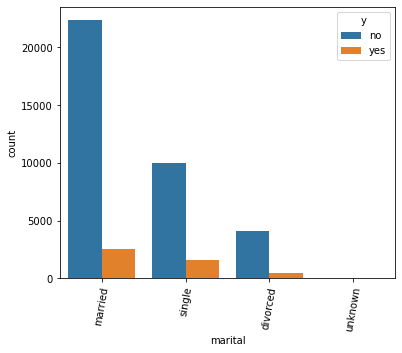

In [16]:
# checking the percent of each category in marital status
countplot('marital', 'y')

- majority of the customers are married (61%) followed by single, divorced and unknown
- most of the married people have not subscribed to a term deposit

university.degree      30.0
high.school            23.0
basic.9y               15.0
professional.course    13.0
basic.4y               10.0
basic.6y                6.0
unknown                 4.0
illiterate              0.0
Name: education, dtype: float64


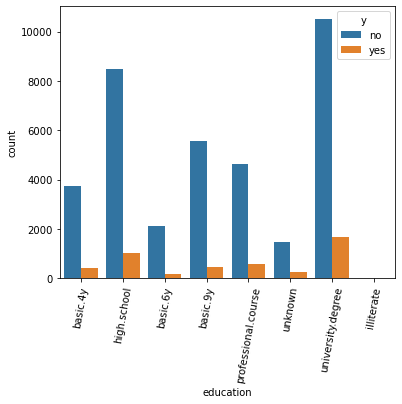

In [17]:
countplot('education', 'y')

- most of the people have a university degree (30%) followed by high school and basic 9y
- most of the people have not subscribed to the term deposit

yes        52.0
no         45.0
unknown     2.0
Name: housing, dtype: float64


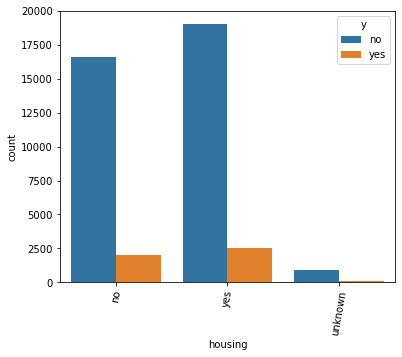

In [18]:
countplot('housing', 'y')

- majority of the customers have a housing loan
- and most of the customers with housing loans have not subscribed to the term deposit

nonexistent    86.0
failure        10.0
success         3.0
Name: poutcome, dtype: float64


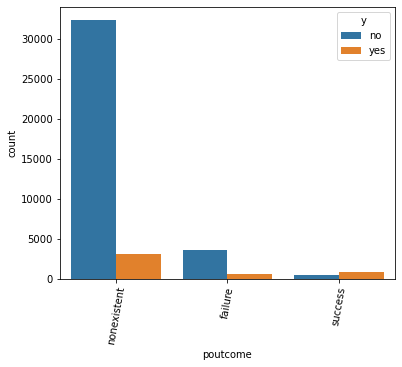

In [19]:
countplot('poutcome', 'y')

 - the previous marketing campaign outcome does not exists for most customers. It means that most of the customers are new customers who have not been contacted earlier.
 - And most of the clients who have been contacted, **did subscribe** for a term deposit

thu    21.0
mon    21.0
wed    20.0
tue    20.0
fri    19.0
Name: day_of_week, dtype: float64


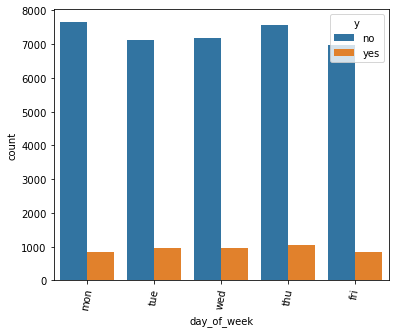

In [20]:
countplot('day_of_week','y')

- all the days have the similar distribution for both the classes
- this feature might not be of much use

<AxesSubplot:>

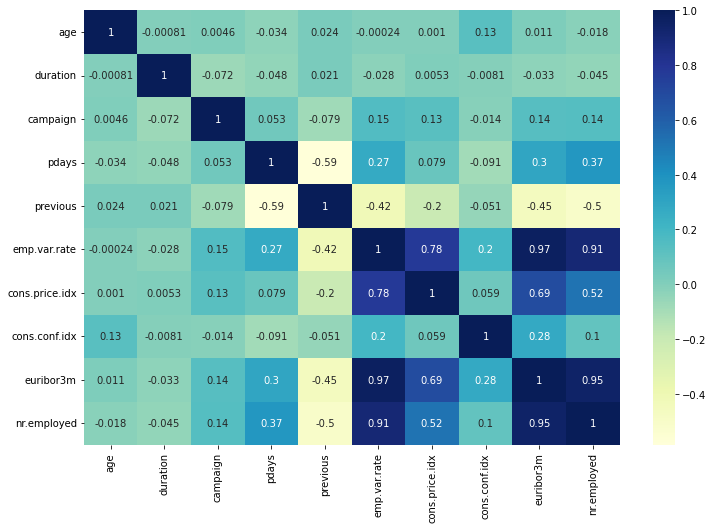

In [21]:
# checking correlation for numerical features
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(), annot = True, cmap = 'YlGnBu')

- **emp.var.rate, cons.price.idx, euribor3m** and **nr.employed** have very high correlation
- these features shall be removed since they do not contribute any different from the features that they are in high correlation with

### Data Pre-Processing and cleaning

In [22]:
# 1. removing highly correlated features
df.drop(['euribor3m', 'nr.employed'], axis = 1, inplace = True)

In [23]:
# 2. transforming categories in education - by checking for 5th character in education to be a dot - '.'
df['education'] = df['education'].apply(lambda x : 'basic' if x[5] == '.' else x)

In [24]:
df.education.value_counts()

basic                  12512
university.degree      12164
high.school             9512
professional.course     5240
unknown                 1730
illiterate                18
Name: education, dtype: int64

In [25]:
# 3. dropping unknown from marital and JOB
df = df[df.marital != 'unknown']
df = df[df.job != 'unknown']

In [26]:
# 4. dropping illiterate from education
df = df[df.education != 'illiterate']

In [27]:
# 5. label encoding the dependant variable - y
df['y'] = df['y'].apply(lambda x : 1 if x == 'yes' else 0)

### Data Preparation for training

In [28]:
# splitting data into X and y
X = df.drop('y', axis = 1)
y = df['y']

# getting dummies
X = pd.get_dummies(X)

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32605, 56)
(8152, 56)
(32605,)
(8152,)


# Model evaluation criterion

**Possible wrong predictions**
- Predicting a client will subscribe to the term deposit but in reality the client will not subscribe - Loss of resources
- Predicting a client will not subscribe to the term deposit but in reality the customer was going to subscribe - Loss of opportunity

**Case Importance**
- The second case is more important - losing a potential client by predicting that he/she will not subscribe is more important
- This is False Negative - we need to reduce FN - hence `increase Recall`

**General Case**
- We can optimise the F1-Score in order to have a more generalised model that reduces both FP and FN

### Model Building without Hyperparameter tuning

In [30]:
# functions to predict model performance

def model_performance_with_threshold(model, predictors, target, threshold=0.5):

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)  # will round every prob > thresh to 1

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=["Value"],
    )

    return df_perf.T


def model_performance(target,pred):    
    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=["Value"],)
    
    return df_perf.T

### 1. Logistic Regression

In [31]:
# training
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [32]:
# prediction
y_pred_lr = lr.predict(X_test)

In [33]:
# result
print("TEST SET RESULT")
lr_result_test= model_performance_with_threshold(lr, X_test, y_test, threshold=0.5)
lr_result_test

TEST SET RESULT


,Value
Accuracy,0.903705
Recall,0.367102
Precision,0.622921
F1,0.461960


### 2. Support Vector Classifier

In [34]:
# training
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [35]:
# prediction
y_pred_svc = svc.predict(X_test)

In [36]:
# result
print("TEST SET RESULT")
svc_result_test = model_performance(y_test, y_pred_svc)
svc_result_test

TEST SET RESULT


,Value
Accuracy,0.904073
Recall,0.296296
Precision,0.666667
F1,0.410256


### 3. Random Forest Classifier

In [37]:
# training
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [38]:
# prediction
y_pred_rf = rf.predict(X_test)

In [39]:
# result
print("TEST SET RESULT")
rf_result_test = model_performance(y_test, y_pred_rf)
rf_result_test

TEST SET RESULT


,Value
Accuracy,0.910697
Recall,0.466231
Precision,0.642643
F1,0.540404


### Model Building with Hyperparameter tuning 

### 1. Logistic Regression

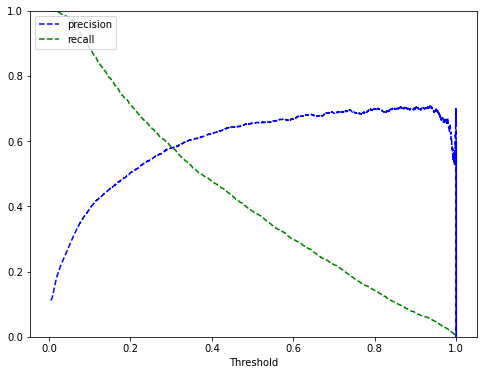

In [40]:
# Finding optimal parameter from Precision-recall curve 

y_scores = lr.predict_proba(X_train)[:, 1]
prec, rec, tre = precision_recall_curve(y_train, y_scores)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(8, 6))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

- for a threshold of around **`0.1`**, the Recall is significantly high
- Since for this problem, we need to increase the recall to reduce the FN rate, we will choose threshold as **0.1**

In [41]:
lr_result_hyp = model_performance_with_threshold(lr, X_test, y_test, threshold=0.1)
lr_result_hyp

,Value
Accuracy,0.831084
Recall,0.891068
Precision,0.390453
F1,0.542980


- The recall is significantly increased for a lesser threshold value of **0.1**
- **For a more generalised mode, we can choose a threshold around `0.3` for a balanced precision-recall and good F1-score**

### 2. Support Vector Classifier

In [42]:
svc = SVC(C = 10 ,class_weight='balanced', gamma='auto')
svc.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', gamma='auto')

In [43]:
y_pred_svc_hyp = svc.predict(X_test)

In [44]:
svc_result_hyp = model_performance(y_test,y_pred_svc_hyp)
svc_result_hyp

,Value
Accuracy,0.890211
Recall,0.435730
Precision,0.514801
F1,0.471976


- The recall is increases significantly than the previus SVC model
- Increasing the regularisation parameter and taking gamma as auto, results in a better recall and F1-score

### 3. Random Forest Classifier

In [45]:
rf = RandomForestClassifier(n_estimators=1000,n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [46]:
y_pred_rf_hyp = rf.predict(X_test)

In [47]:
rf_result_hyp = model_performance(y_test,y_pred_rf_hyp)
rf_result_hyp

,Value
Accuracy,0.911065
Recall,0.478214
Precision,0.640876
F1,0.547723


- Recall **increases slightly** with an increase in F1-score as well.
- with 1000 estimators, the model has a better recall and F1-score with an increase in the accuracy.

### Model Performance Summary

In [48]:
# training performance comparison

def summary(model1, model2, model3, tune = 'without'):
    models_train_comp_df = pd.concat(
        [
            model1, 
            model2, 
            model3
        ],
        axis=1,
    )
    models_train_comp_df.columns = [
        "Logistic Regression ",
        "Support Vector Classifier",
        "Random Forest Classifier",
    ]

    print(f"Model performance {tune} hyperparameter tuning")
    return models_train_comp_df

In [49]:
summary(lr_result_test, svc_result_test, rf_result_test)

Model performance without hyperparameter tuning


,Logistic Regression,Support Vector Classifier,Random Forest Classifier
Accuracy,0.903705,0.904073,0.910697
Recall,0.367102,0.296296,0.466231
Precision,0.622921,0.666667,0.642643
F1,0.461960,0.410256,0.540404


In [50]:
summary(lr_result_hyp, svc_result_hyp, rf_result_hyp, tune = 'with')

Model performance with hyperparameter tuning


,Logistic Regression,Support Vector Classifier,Random Forest Classifier
Accuracy,0.831084,0.890211,0.911065
Recall,0.891068,0.435730,0.478214
Precision,0.390453,0.514801,0.640876
F1,0.542980,0.471976,0.547723


### Conclusion

- **Without Hyperparameter Tuning**
    - The best recall score of `0.466` is given by `Random Forest Classifier` with an f1-score of **0.540**
    - The best accuracy score of `91.06%` is given by `Random Forest Classifier`
    - The models does not perform well on the test set in terms of recall. The accuracy on the other hand is significant.


- **With Hyperparameter Tuning**
    - The best recall score of `0.891` is given by `Logistic Regression` with a balanced F1-score of **0.542**
    - The best accuracy score of `91.10%` is given by `Random Forest Classifier`
    - The models perform better in terms of recall and have maintained the F1-score and overall accuracy.


- **`Logisitic Regression`** model with hyperparameter tuning is able to give a balanced **`F1-score of 0.542`** and a decent **`accuracy of 83.10%`**. This model outperforms all the other models in terms of reducing the FN cases and increase the Recall to **`0.891`**
- The Logisitic Regression model is tuned with a threshold value of **0.1**.
- We can choose a threshold value of **0.3** for a generalised model with a better F1-score that reduces both FN and FP
- **Hence this model can be used in practice and is a good model**

### Saving the model

In [51]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(lr_result_hyp, open(filename, 'wb'))